## Conexión de Colab al drive para carga de datos y persistencia de los modelos

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Based on: https://www.kaggle.com/pramod722445/melanoma-basic-training

In [2]:
# !pip install mlflow
# !pip install focal-loss

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sn
import albumentations as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import concatenate

# from focal_loss import BinaryFocalLoss

# import mlflow
# import mlflow.keras

## Parámetros
* IMG_SIZE: Tamaño de entrada de las imágenes
* MODEL_IMG_SIZE: Tamaño al que se redimensionarán las imágenes para entrar como input del modelo.
* BATCH_SIZE: Tamaño del batch de datos a la hora de entrenamiento
* MODEL_NAME: Indica el modelo base que se usará para el entrenamiento
* TRAINABLE: Indica si se congelará o no los pesos del modelo base

In [3]:
# random_state_list = np.random.randint(2**32, size=5).tolist()
# random_state_list
random_state_list = [2708313925, 2352347594, 1769840296, 3348530533, 1595184898]
random_state_list

[2708313925, 2352347594, 1769840296, 3348530533, 1595184898]

In [4]:
IMG_SIZE = 512
MODEL_IMG_SIZE = 299
MODEL_METADATA_SIZE = 9
BATCH_SIZE = 32
MODEL_NAME = 'xception.Xception' # 'MobileNetV2', 'ResNet50', 'xception.Xception', 'ResNet101'
TRAINABLE = True
N_EPOCHS = 5
MELANOMA_INDEX = 1
MODEL_OUTPUT_TYPE = 'multiclass' # 'binary', 'multiclass'
RAND_STATE_LIST = random_state_list

## Copiando imáganes desde el drive al storage local de colab

In [5]:
! cp gdrive/MyDrive/melanoma_classification/dataset/jpeg_{IMG_SIZE}_all.zip .

! echo 'unzipping files...'
! unzip -o -q jpeg_{IMG_SIZE}_all.zip
! rm jpeg_*.zip
! echo 'unzip done'

unzipping files...
unzip done


In [6]:
! ls

gdrive	     test_2020	    train_2019	    train_2020
sample_data  test_2020.csv  train_2019.csv  train_2020.csv


## Cargando el dataset
Se eliminarán los datos en los que la metadata tenga algún valor nulo.

In [7]:
def load_data(prefix='train_2020'):
  df = pd.read_csv(f'{prefix}.csv')
  df = df.dropna(subset=['sex', 'age_approx']).reset_index(drop=True)

  df['image_name_jpg'] = df['image_name'].apply(lambda x: f'{prefix}/{x}.jpg')
  df['dataset_name'] = prefix

  return df

In [8]:
df_data = pd.concat([load_data(prefix='train_2019'), load_data(prefix='train_2020')], ignore_index=True)
df = df_data.copy()
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name_jpg,dataset_name
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767,train_2019/ISIC_0000000.jpg,train_2019
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,train_2019/ISIC_0000001.jpg,train_2019
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,train_2019/ISIC_0000002.jpg,train_2019
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,train_2019/ISIC_0000003.jpg,train_2019
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,train_2019/ISIC_0000004.jpg,train_2019


In [9]:
def apply_diagnosis_mapping(df):
  map_2019 = {'BCC': 'UNKNOWN', 'AK': 'UNKNOWN', 'SCC': 'UNKNOWN', 
              'VASC': 'UNKNOWN', 'DF': 'UNKNOWN', 'NV': 'NV', 'MEL': 'MEL',
              'BKL': 'BKL'}

  map_2020 = {'atypical melanocytic proliferation': 'UNKNOWN', 
              'cafe-au-lait macule': 'UNKNOWN', 'lentigo NOS': 'BKL',
              'lichenoid keratosis': 'BKL', 'melanoma': 'MEL', 'nevus': 'NV',
              'seborrheic keratosis': 'BKL', 'solar lentigo': 'BKL', 
              'unknown': 'UNKNOWN'}

  if MODEL_OUTPUT_TYPE == 'multiclass':
    target_map = {'BKL': 0, 'MEL': 1, 'NV': 2, 'UNKNOWN': 3}
  else:
    target_map = {'BKL': 0, 'MEL': 1, 'NV': 0, 'UNKNOWN': 0}

  def df_mapper(row):
    if '2019' in row['dataset_name']:
      return map_2019[row['diagnosis']]
    elif '2020' in row['dataset_name']:
        return map_2020[row['diagnosis']]
  
  df['diagnosis_mapped'] = df.apply(df_mapper, axis=1)
  df['target'] = df['diagnosis_mapped'].apply(lambda x: target_map[x])

  return df

df = apply_diagnosis_mapping(df)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name_jpg,dataset_name,diagnosis_mapped
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,2,4,1022,767,train_2019/ISIC_0000000.jpg,train_2019,NV
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,2,18,1022,767,train_2019/ISIC_0000001.jpg,train_2019,NV
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,train_2019/ISIC_0000002.jpg,train_2019,MEL
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,2,24,1022,767,train_2019/ISIC_0000003.jpg,train_2019,NV
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,train_2019/ISIC_0000004.jpg,train_2019,MEL


In [10]:
columns = ['diagnosis_mapped', 'benign_malignant']
df.groupby(columns, as_index=False).agg({'image_name': 'count'}).sort_values(columns)

,diagnosis_mapped,benign_malignant,image_name
0,BKL,benign,2821
1,MEL,malignant,5021
2,NV,benign,17748
3,UNKNOWN,benign,32362


In [11]:
def apply_anatom_site_mapping(df):
  df.loc[df['anatom_site_general_challenge'].isna(), 'anatom_site_general_challenge'] = 'nan'

  map_anatom_site = {'anterior torso': 'torso', 'lateral torso': 'torso',
                    'posterior torso': 'torso', 'torso': 'torso', 
                    'head/neck': 'head/neck', 
                    'lower extremity': 'lower extremity', 
                    'oral/genital': 'oral/genital', 'palms/soles': 'palms/soles',
                    'upper extremity': 'upper extremity', 'nan': 'nan'}

  df['anatom_site_mapped'] = df['anatom_site_general_challenge'].apply(lambda x: map_anatom_site[x])

  return df

df = apply_anatom_site_mapping(df)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name_jpg,dataset_name,diagnosis_mapped,anatom_site_mapped
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,2,4,1022,767,train_2019/ISIC_0000000.jpg,train_2019,NV,torso
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,2,18,1022,767,train_2019/ISIC_0000001.jpg,train_2019,NV,torso
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,train_2019/ISIC_0000002.jpg,train_2019,MEL,upper extremity
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,2,24,1022,767,train_2019/ISIC_0000003.jpg,train_2019,NV,upper extremity
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,train_2019/ISIC_0000004.jpg,train_2019,MEL,torso


In [12]:
columns = ['anatom_site_mapped', 'benign_malignant']
df.groupby(columns, as_index=False).agg({'image_name': 'count'}).sort_values(['anatom_site_mapped', 'benign_malignant'])

,anatom_site_mapped,benign_malignant,image_name
0,head/neck,benign,5471
1,head/neck,malignant,950
2,lower extremity,benign,12446
3,lower extremity,malignant,911
4,nan,benign,2841
5,nan,malignant,100
6,oral/genital,benign,160
7,oral/genital,malignant,23
8,palms/soles,benign,567
9,palms/soles,malignant,201


## Encoding de variables y normalización

In [13]:
def apply_encoding_and_normalize(df):
  # sex
  df['sex_dummy'] = (df['sex'] == 'female').astype(int)

  # anatom_site_mapped
  sites = ['torso', 'upper extremity', 'lower extremity', 'head/neck', 'palms/soles', 'oral/genital', 'nan']
  for site in sites:
    column_name = '_' + site.replace(' ', '_').replace('/', '_')
    df[column_name] = (df['anatom_site_mapped'] == site).astype(int)

  # age
  max_age = 90 # df['age_approx'].max()
  df['age_approx_normalized'] = df['age_approx'] / max_age

  return df

df = apply_encoding_and_normalize(df)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name_jpg,dataset_name,diagnosis_mapped,anatom_site_mapped,sex_dummy,_torso,_upper_extremity,_lower_extremity,_head_neck,_palms_soles,_oral_genital,_nan,age_approx_normalized
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,2,4,1022,767,train_2019/ISIC_0000000.jpg,train_2019,NV,torso,1,1,0,0,0,0,0,0,0.611111
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,2,18,1022,767,train_2019/ISIC_0000001.jpg,train_2019,NV,torso,1,1,0,0,0,0,0,0,0.333333
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,train_2019/ISIC_0000002.jpg,train_2019,MEL,upper extremity,1,0,1,0,0,0,0,0,0.666667
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,2,24,1022,767,train_2019/ISIC_0000003.jpg,train_2019,NV,upper extremity,0,0,1,0,0,0,0,0,0.333333
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,train_2019/ISIC_0000004.jpg,train_2019,MEL,torso,0,1,0,0,0,0,0,0,0.888889


### Construyendo dataframe final

In [14]:
final_columns = ['image_name_jpg', 'sex_dummy', 'age_approx_normalized', 
                 '_torso', '_upper_extremity', '_lower_extremity', '_head_neck', 
                 '_palms_soles', '_oral_genital', '_nan', 'target']
df_final = df[final_columns]

df_final.head()

,image_name_jpg,sex_dummy,age_approx_normalized,_torso,_upper_extremity,_lower_extremity,_head_neck,_palms_soles,_oral_genital,_nan,target
0,train_2019/ISIC_0000000.jpg,1,0.611111,1,0,0,0,0,0,0,2
1,train_2019/ISIC_0000001.jpg,1,0.333333,1,0,0,0,0,0,0,2
2,train_2019/ISIC_0000002.jpg,1,0.666667,0,1,0,0,0,0,0,1
3,train_2019/ISIC_0000003.jpg,0,0.333333,0,1,0,0,0,0,0,2
4,train_2019/ISIC_0000004.jpg,0,0.888889,1,0,0,0,0,0,0,1


## Visualización de los datos

In [15]:
def image_from_diagnosis(value, column='diagnosis', sample=False):
  if sample:
    path = df[df[column] == value].sample(1).iloc[0]['image_name_jpg']
  else:
    path = df[df[column] == value].iloc[0]['image_name_jpg']
  img_bgr = cv2.imread(path)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  return img_rgb

BKL


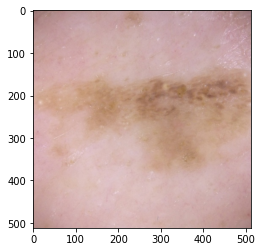

MEL


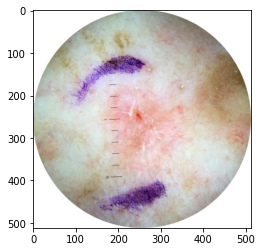

NV


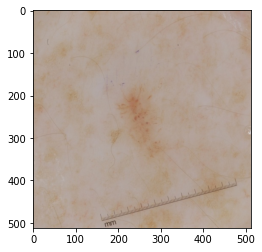

UNKNOWN


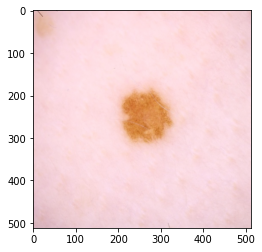

In [16]:
diagnosis_list = [{'value': 'BKL',     'column': 'diagnosis_mapped', 'sample': True}, 
                  {'value': 'MEL',     'column': 'diagnosis_mapped', 'sample': True}, 
                  {'value': 'NV',      'column': 'diagnosis_mapped', 'sample': True}, 
                  {'value': 'UNKNOWN', 'column': 'diagnosis_mapped', 'sample': True}]

for diag in diagnosis_list:
  print(diag['value'])
  img_rgb = image_from_diagnosis(**diag)
  plt.imshow(img_rgb)
  plt.show()

## Definición de la arquitectura del modelo
La base del modelo partirá de un Mobilenet Version 2 preentrenado previamente con el dataset de imagenet. Se agregarán unas capas adicionales fully connected terminando con una capa adicional para que la salida sea binaria.


### Métricas custom

In [17]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def custom_f1_metric(y_true, y_pred):
  y_true_binary = y_true[:, MELANOMA_INDEX]
  y_pred_binary = y_pred[:, MELANOMA_INDEX]
  return f1_m(y_true_binary, y_pred_binary)

auc_function = tf.keras.metrics.AUC()

def custom_auc_metric(y_true, y_pred):
  y_true_binary = y_true[:, MELANOMA_INDEX]
  y_pred_binary = y_pred[:, MELANOMA_INDEX]
  return auc_function(y_true_binary, y_pred_binary)

### Recargando el modelo de ser necesario

In [19]:
reload_model = True
timestamp = '20211116_224518'

if reload_model:
  model = load_model(f'gdrive/MyDrive/melanoma_classification/trained_models/MODEL_3/{timestamp}/melanoma_classification.h5', 
                     custom_objects={'custom_auc_metric': custom_auc_metric})
  f = open(f'gdrive/MyDrive/melanoma_classification/trained_models/MODEL_3/{timestamp}/log_data.json', "r")
  log_data = json.loads(f.read())

  IMG_SIZE = log_data['IMG_SIZE']
  MODEL_IMG_SIZE = log_data['MODEL_IMG_SIZE']
  MODEL_METADATA_SIZE = log_data['MODEL_METADATA_SIZE']
  BATCH_SIZE = log_data['BATCH_SIZE']
  MODEL_NAME = log_data['MODEL_NAME']
  TRAINABLE = log_data['TRAINABLE']
  N_EPOCHS = log_data['N_EPOCHS']
  MELANOMA_INDEX = log_data['MELANOMA_INDEX']
  MODEL_OUTPUT_TYPE = log_data['MODEL_OUTPUT_TYPE']
  RAND_STATE_LIST = log_data['RAND_STATE_LIST']

  print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          5120        ['dense_input[0][0]']            
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 512)         2048        ['dense[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 512)          0           ['batch_normalization_4[0][0]

### Creando la rama convolucional

In [ ]:
input_shape = (MODEL_IMG_SIZE, MODEL_IMG_SIZE, 3)

exec_str = f'''
base_model = tf.keras.applications.{MODEL_NAME}(input_shape=input_shape, 
                                                include_top=False, 
                                                weights="imagenet")
'''

exec(exec_str)

In [ ]:
base_model.trainable = TRAINABLE

In [ ]:
def build_cnn_branch():
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  return model

cnn_branch = build_cnn_branch()

In [ ]:
cnn_branch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


### Creando rama para la metadata

In [ ]:
def build_metadata_branch():
    model = Sequential()
    model.add(Dense(512, input_dim=MODEL_METADATA_SIZE))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.swish))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation(tf.keras.activations.swish))
    return model

metadata_branch = build_metadata_branch()

In [ ]:
metadata_branch.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120      
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                      

### Combinando la rama comvolucional y la rama de la metadata

In [ ]:
def build_concatenated_network(
    cnn_model, metadata_model, model_output_type='binary'):
  combined_input = tf.concat([cnn_model.output, metadata_model.output], axis=1)

  x = Dropout(0.5)(combined_input)

  if model_output_type == 'multiclass':
    x = Dense(4, activation="softmax")(x)
  else:
    x = Dense(1, activation="sigmoid")(x)

  model = Model(inputs=[cnn_model.input, metadata_model.input], outputs=x)
  return model

concatenated_model = build_concatenated_network(
    cnn_branch, metadata_branch, model_output_type=MODEL_OUTPUT_TYPE)

Trabajaremos con el AUC puesto que es una métrica útil para data desbalanceada, además, no es necesario definir un threshold.

In [ ]:
# we are using adam you can use other to optimize better
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, # 0.0001, 0.001
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

if MODEL_OUTPUT_TYPE == 'multiclass':
  loss = "categorical_crossentropy"
  metrics = ['accuracy', custom_auc_metric]
else:
  loss = "binary_crossentropy"
  metrics = ['accuracy', auc_function]

concatenated_model.compile(loss=loss,
                           optimizer=optimizer,
                           metrics=metrics)
print(concatenated_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          5120        ['dense_input[0][0]']            
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 512)         2048        ['dense[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 512)          0           ['batch_normalization_4[0][0]

In [ ]:
"""
# Build Model according to your output
def build_model():
  model = Sequential()
  model.add(base_model) 
  model.add(GlobalAveragePooling2D())

  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5)) # change dropout get better result
  model.add(BatchNormalization())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(BatchNormalization())

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(BatchNormalization())

  model.add(Dense(4, activation="softmax")) # output is 0 or 1 binary 
    
  # now compile model
  # we are using adam you can use other to optimize better
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, # 0.0001, 0.001
                                       beta_1=0.9, 
                                       beta_2=0.999,  
                                       amsgrad=False)
  # This is important part of model 
  # Number of positive image is less than number of negative image
  # we use AUC metrics
  # metrics = [precision_m, recall_m, f1_m]
  # metrics = tf.keras.metrics.AUC(name="auc")
  model.compile(loss="categorical_crossentropy", 
                #loss=BinaryFocalLoss(gamma=2),
                optimizer=optimizer,
                metrics=['accuracy', custom_auc_metric, custom_f1_metric])
  print(model.summary())
  return model

model=build_model()
""";

"""
# Build Model according to your output
def build_model():
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(4, activation="softmax"))

  # we are using adam you can use other to optimize better
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, # 0.0001, 0.001
                                       beta_1=0.9, 
                                       beta_2=0.999,  
                                       amsgrad=False)
  
  # This is important part of model 
  # Number of positive image is less than number of negative image
  # we use AUC metrics
  # metrics = tf.keras.metrics.AUC(name="auc")
  # loss=BinaryFocalLoss(gamma=2),
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=['accuracy', custom_auc_metric])
  print(model.summary())
  return model

model=build_model()
""";

## Construyendo generadores

In [20]:
dataset_size = df_final.shape[0]
print(f'Total samples: {dataset_size}')
classes, counts = np.unique(df_final["target"],return_counts=True)
pd.DataFrame({'classes': classes, 'counts': counts})

Total samples: 57952


,classes,counts
0,0,2821
1,1,5021
2,2,17748
3,3,32362


La clases están fuertemente desbalanceados por lo que multiplicaremos la clase 1 (tiene melanoma) varias veces y agregaremos data augmentation para evitar overfitting

In [21]:
train_size = int(dataset_size - np.ceil(dataset_size * 0.2))
valid_size = int(np.ceil(dataset_size * 0.15))
test_size = int(dataset_size - valid_size - train_size)
train_size, valid_size, test_size

(46361, 8693, 2898)

In [22]:
RAND_STATE_LIST

[2708313925, 2352347594, 1769840296, 3348530533, 1595184898]

In [23]:
train, valid = train_test_split(df_final, 
                                test_size=valid_size+test_size, 
                                stratify=df_final['target'], 
                                random_state=RAND_STATE_LIST[0])
valid, test = train_test_split(valid, 
                               test_size=test_size, 
                               stratify=valid['target'], 
                               random_state=RAND_STATE_LIST[1])

train.shape, valid.shape, test.shape

((46361, 11), (8693, 11), (2898, 11))

In [24]:
classes, counts = np.unique(train["target"],return_counts=True)
train_count_df = pd.DataFrame({'classes': classes, 'train_counts': counts})

classes, counts = np.unique(valid["target"],return_counts=True)
valid_count_df = pd.DataFrame({'classes': classes, 'valid_counts': counts})

classes, counts = np.unique(test["target"],return_counts=True)
test_count_df = pd.DataFrame({'classes': classes, 'test_counts': counts})

train_count_df.merge(valid_count_df, on='classes').merge(test_count_df, on='classes')

,classes,train_counts,valid_counts,test_counts
0,0,2257,423,141
1,1,4017,753,251
2,2,14198,2662,888
3,3,25889,4855,1618


Data augmentation para permitir que el modelo generalice más a partir de la data de entrenamiento

In [25]:
def blur(img):
  if random.getrandbits(1):
    return img
  return cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)

In [26]:
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.Blur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    # A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    # A.Resize(image_size, image_size),
    # A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),    
    A.Normalize()
])

transforms_val = A.Compose([
    # A.Resize(image_size, image_size),
    A.Normalize()
])

In [27]:
def aug_train(image):
  aug_data = transforms_train(image=image)
  aug_img = aug_data["image"]
  return aug_img

def aug_valid(image):
  aug_data = transforms_val(image=image)
  aug_img = aug_data["image"]
  return aug_img

### Generadores de imagenes

In [28]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=90,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.5, 1.5],
                                   preprocessing_function=blur)

valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen  = ImageDataGenerator(rescale=1/255)

"""
train_datagen = ImageDataGenerator(preprocessing_function=aug_train)
valid_datagen = ImageDataGenerator(preprocessing_function=aug_valid)
""";

### Definiendo los generadores de datos a partir de los dataframes de pandas

In [29]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='/content',
    x_col='image_name_jpg',
    y_col=train.columns[1:],
    target_size=(MODEL_IMG_SIZE, MODEL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid,
    directory='/content',
    x_col='image_name_jpg',
    y_col=valid.columns[1:],
    target_size=(MODEL_IMG_SIZE, MODEL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw', 
    shuffle=False)

testing_generator = valid_datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content',
    x_col='image_name_jpg',
    y_col=test.columns[1:],
    target_size=(MODEL_IMG_SIZE, MODEL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw', 
    shuffle=False)

Found 46361 validated image filenames.
Found 8693 validated image filenames.
Found 2898 validated image filenames.


In [30]:
class OwnDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, gen, model_output_type="binary"):
    self.gen = gen
    self.model_output_type = model_output_type

    if self.model_output_type == 'multiclass':
      self.__data_output = self.__data_output_multiclass 
    else:
      self.__data_output = self.__data_output_binary 

  def __len__(self):
    return self.gen.__len__()

  def __getitem__(self, index):
    data = self.gen.__getitem__(index)
    return self.__data_output(data)

  def on_epoch_end(self):
    self.gen.on_epoch_end()
    
  def __data_output_multiclass(self, data):
    imgs = data[0]
    meta = data[1][:,:-1]

    a = data[1][:,-1:].squeeze().astype(int)
    targets = np.zeros((a.size, 4))
    targets[np.arange(a.size), a] = 1

    return [imgs, meta], targets

  def __data_output_binary(self, data):
    imgs = data[0]
    meta = data[1][:,:-1]

    targets = data[1][:,-1:].squeeze().astype('float32')

    return [imgs, meta], targets

  @property
  def classes(self):
    labels = self.gen.labels
    return labels[:,-1:].squeeze().astype(int)

In [31]:
own_train_generator = OwnDataGenerator(train_generator, model_output_type=MODEL_OUTPUT_TYPE)
own_validation_generator = OwnDataGenerator(validation_generator, model_output_type=MODEL_OUTPUT_TYPE)
own_testing_generator = OwnDataGenerator(testing_generator, model_output_type=MODEL_OUTPUT_TYPE)

### Procediendo a hacer fit del modelo

In [ ]:
concatenated_model.fit(
    own_train_generator,
    # epochs=10,
    epochs=N_EPOCHS,
    validation_data=own_validation_generator)

# mlflow.keras.autolog()
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_custom_auc_metric', min_delta=0, patience=1, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
"""
model.fit(
    train_generator,
    epochs=2, #epochs=N_EPOCHS,
    #callbacks=[early_stopping],
    validation_data=validation_generator
)
""";

Epoch 1/5
1449/1449 [==============================] - 1583s 1s/step - loss: 0.5980 - accuracy: 0.7779 - custom_auc_metric: 0.8302 - val_loss: 0.4338 - val_accuracy: 0.8427 - val_custom_auc_metric: 0.8783
Epoch 2/5
1449/1449 [==============================] - 1564s 1s/step - loss: 0.4607 - accuracy: 0.8329 - custom_auc_metric: 0.8896 - val_loss: 0.4037 - val_accuracy: 0.8513 - val_custom_auc_metric: 0.8971
Epoch 3/5
1449/1449 [==============================] - 1553s 1s/step - loss: 0.4136 - accuracy: 0.8530 - custom_auc_metric: 0.9033 - val_loss: 0.3734 - val_accuracy: 0.8655 - val_custom_auc_metric: 0.9075
Epoch 4/5
1449/1449 [==============================] - 1552s 1s/step - loss: 0.3775 - accuracy: 0.8648 - custom_auc_metric: 0.9115 - val_loss: 0.3672 - val_accuracy: 0.8704 - val_custom_auc_metric: 0.9145
Epoch 5/5
1449/1449 [==============================] - 1554s 1s/step - loss: 0.3535 - accuracy: 0.8735 - custom_auc_metric: 0.9173 - val_loss: 0.3775 - val_accuracy: 0.8690 - val_c

In [ ]:
concatenated_model.fit(
    own_train_generator,
    epochs=N_EPOCHS,
    validation_data=own_validation_generator)

Epoch 1/5
1449/1449 [==============================] - 1554s 1s/step - loss: 0.3317 - accuracy: 0.8830 - custom_auc_metric: 0.9218 - val_loss: 0.3617 - val_accuracy: 0.8730 - val_custom_auc_metric: 0.9242
Epoch 2/5
1449/1449 [==============================] - 1549s 1s/step - loss: 0.3123 - accuracy: 0.8883 - custom_auc_metric: 0.9264 - val_loss: 0.3112 - val_accuracy: 0.8920 - val_custom_auc_metric: 0.9284
Epoch 3/5
1449/1449 [==============================] - 1549s 1s/step - loss: 0.2931 - accuracy: 0.8955 - custom_auc_metric: 0.9305 - val_loss: 0.3339 - val_accuracy: 0.8888 - val_custom_auc_metric: 0.9321
Epoch 4/5
1449/1449 [==============================] - 1558s 1s/step - loss: 0.2816 - accuracy: 0.8982 - custom_auc_metric: 0.9336 - val_loss: 0.3352 - val_accuracy: 0.8859 - val_custom_auc_metric: 0.9350
Epoch 5/5
1449/1449 [==============================] - 1555s 1s/step - loss: 0.2662 - accuracy: 0.9034 - custom_auc_metric: 0.9366 - val_loss: 0.3284 - val_accuracy: 0.8920 - val_c

In [ ]:
concatenated_model.fit(
    own_train_generator,
    epochs=N_EPOCHS,
    validation_data=own_validation_generator)

Epoch 1/5
1449/1449 [==============================] - 1551s 1s/step - loss: 0.2461 - accuracy: 0.9118 - custom_auc_metric: 0.9392 - val_loss: 0.3437 - val_accuracy: 0.8899 - val_custom_auc_metric: 0.9405
Epoch 2/5
1449/1449 [==============================] - 1551s 1s/step - loss: 0.2374 - accuracy: 0.9141 - custom_auc_metric: 0.9419 - val_loss: 0.3259 - val_accuracy: 0.8941 - val_custom_auc_metric: 0.9429
Epoch 3/5
1449/1449 [==============================] - 1560s 1s/step - loss: 0.2256 - accuracy: 0.9185 - custom_auc_metric: 0.9441 - val_loss: 0.3152 - val_accuracy: 0.8964 - val_custom_auc_metric: 0.9453
Epoch 4/5
1449/1449 [==============================] - 1553s 1s/step - loss: 0.2140 - accuracy: 0.9232 - custom_auc_metric: 0.9465 - val_loss: 0.3242 - val_accuracy: 0.9007 - val_custom_auc_metric: 0.9476
Epoch 5/5
1449/1449 [==============================] - 1544s 1s/step - loss: 0.2031 - accuracy: 0.9281 - custom_auc_metric: 0.9487 - val_loss: 0.3287 - val_accuracy: 0.9034 - val_c

In [ ]:
concatenated_model.fit(
    own_train_generator,
    epochs=3,
    validation_data=own_validation_generator)

Epoch 1/3
1449/1449 [==============================] - 1543s 1s/step - loss: 0.1913 - accuracy: 0.9307 - custom_auc_metric: 0.9507 - val_loss: 0.3393 - val_accuracy: 0.8962 - val_custom_auc_metric: 0.9516
Epoch 2/3
1449/1449 [==============================] - 1544s 1s/step - loss: 0.1874 - accuracy: 0.9332 - custom_auc_metric: 0.9525 - val_loss: 0.3058 - val_accuracy: 0.9087 - val_custom_auc_metric: 0.9534
Epoch 3/3
1449/1449 [==============================] - 1544s 1s/step - loss: 0.1768 - accuracy: 0.9364 - custom_auc_metric: 0.9543 - val_loss: 0.3162 - val_accuracy: 0.9084 - val_custom_auc_metric: 0.9550


In [ ]:
final_epochs = 18

In [ ]:
metrics = {
    'epoch':          [     1,      2,      3,      4,      5,      6,      7,      8,      9,     10,     11,     12,     13,     14,    15,      16,     17,     18],
    'train_loss':     [0.5980, 0.4607, 0.4136, 0.3775, 0.3535, 0.3317, 0.3123, 0.2931, 0.2816, 0.2662, 0.2461, 0.2374, 0.2256, 0.2140, 0.2031, 0.1913, 0.1874, 0.1768],
    'train_accuracy': [0.7779, 0.8329, 0.8530, 0.8648, 0.8735, 0.8830, 0.8883, 0.8955, 0.8982, 0.9034, 0.9118, 0.9141, 0.9185, 0.9232, 0.9281, 0.9307, 0.9332, 0.9364],
    'train_auc':      [0.8302, 0.8896, 0.9033, 0.9115, 0.9173, 0.9218, 0.9264, 0.9305, 0.9336, 0.9366, 0.9392, 0.9419, 0.9441, 0.9465, 0.9487, 0.9507, 0.9525, 0.9543],
    'valid_loss':     [0.4338, 0.4037, 0.3734, 0.3672, 0.3775, 0.3617, 0.3112, 0.3339, 0.3352, 0.3284, 0.3437, 0.3259, 0.3152, 0.3242, 0.3287, 0.3393, 0.3058, 0.3162],
    'valid_accuracy': [0.8427, 0.8513, 0.8655, 0.8704, 0.8690, 0.8730, 0.8920, 0.8888, 0.8859, 0.8920, 0.8899, 0.8941, 0.8964, 0.9007, 0.9034, 0.8962, 0.9087, 0.9084],
    'valid_auc':      [0.8783, 0.8971, 0.9075, 0.9145, 0.9194, 0.9242, 0.9284, 0.9321, 0.9350, 0.9378, 0.9405, 0.9429, 0.9453, 0.9476, 0.9497, 0.9516, 0.9534, 0.9550],
}

## Some metrics

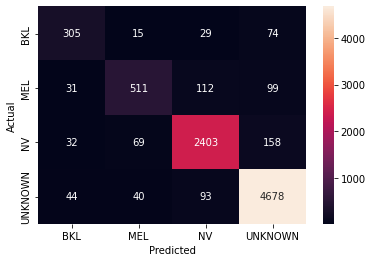

In [33]:
y_pred_proba = model.predict(own_validation_generator)
y_pred = y_pred_proba.argmax(axis=1)

y_true = np.array(own_validation_generator.classes)

confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, fmt="d")
plt.xticks([0.5, 1.5, 2.5, 3.5], ['BKL', 'MEL', 'NV', 'UNKNOWN'])
plt.yticks([0.5, 1.5, 2.5, 3.5], ['BKL', 'MEL', 'NV', 'UNKNOWN'])
plt.show()

In [34]:
dthresh = 0.01
max_f1 = 0
max_threshold = 0
y_true_binary = (y_true == 1).astype(int)
for threshold in np.arange(dthresh, 1, dthresh):
  y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
  current_f1 = f1_score(y_true_binary, y_pred)
  if current_f1 > max_f1:
    max_f1 = current_f1
    max_threshold = threshold
print(max_f1, max_threshold)

0.7388362652232747 0.35000000000000003


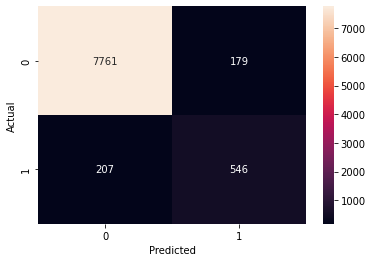

In [35]:
y_pred = (y_pred_proba[:, 1] > max_threshold).astype(int)

confusion_matrix = pd.crosstab((y_true == 1).astype(int), y_pred, 
                               rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()

In [37]:
y_test_pred_proba = model.predict(own_testing_generator)
y_test_pred = y_test_pred_proba.argmax(axis=1)

y_test_true = np.array(testing_generator.classes)

confusion_matrix = pd.crosstab(y_test_true, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, fmt="d")
plt.xticks([0.5, 1.5, 2.5, 3.5], ['BKL', 'MEL', 'NV', 'UNKNOWN'])
plt.yticks([0.5, 1.5, 2.5, 3.5], ['BKL', 'MEL', 'NV', 'UNKNOWN'])
plt.show()

AttributeError: ignored

In [ ]:
y_test_pred_proba = model.predict(own_testing_generator)[:, 1]
y_test_true = np.array(own_testing_generator.classes)
y_test_true = (y_test_true == 1).astype(int)
y_test_pred = (y_test_pred_proba > max_threshold).astype(int)

test_f1 = f1_score(y_test_true, y_test_pred)
print('test_f1:', test_f1)

confusion_matrix = pd.crosstab(y_test_true, y_test_pred, 
                               rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()

### Persistiendo el resultado del modelo en drive para usar en un futuro

In [ ]:
current_time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(current_time_str)
save_dir = f'gdrive/MyDrive/melanoma_classification/trained_models/MODEL_3/{current_time_str}'
! mkdir {save_dir}
#! cp -r mlruns/ {save_dir}


logs_dict = {'IMG_SIZE': IMG_SIZE, 'MODEL_IMG_SIZE': MODEL_IMG_SIZE, 
             'MODEL_METADATA_SIZE': MODEL_METADATA_SIZE, 
             'BATCH_SIZE': BATCH_SIZE, 'MODEL_NAME': MODEL_NAME, 
             'TRAINABLE': TRAINABLE, 'N_EPOCHS': final_epochs, 
             'MELANOMA_INDEX': MELANOMA_INDEX, 
             'MODEL_OUTPUT_TYPE': MODEL_OUTPUT_TYPE, 
             'RAND_STATE_LIST': RAND_STATE_LIST,
             'max_f1': max_f1, 'max_threshold': max_threshold
             }

with open(f'{save_dir}/log_data.json', 'w') as fp:
    json.dump(logs_dict, fp)

# serialize the model to disk
concatenated_model.save(f'{save_dir}/melanoma_classification.h5', save_format="h5")

20211116_224518


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Loading test dataset

In [ ]:
df_test = load_data(prefix='test_2020')
df_test['target'] = 0
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,image_name_jpg,dataset_name,target
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000,test_2020/ISIC_0052060.jpg,test_2020,0
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000,test_2020/ISIC_0052349.jpg,test_2020,0
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000,test_2020/ISIC_0058510.jpg,test_2020,0
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000,test_2020/ISIC_0073313.jpg,test_2020,0
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080,test_2020/ISIC_0073502.jpg,test_2020,0


In [ ]:
df_test = apply_anatom_site_mapping(df_test)
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,image_name_jpg,dataset_name,target,anatom_site_mapped
0,ISIC_0052060,IP_3579794,male,70.0,nan,6000,4000,test_2020/ISIC_0052060.jpg,test_2020,0,nan
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000,test_2020/ISIC_0052349.jpg,test_2020,0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000,test_2020/ISIC_0058510.jpg,test_2020,0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000,test_2020/ISIC_0073313.jpg,test_2020,0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080,test_2020/ISIC_0073502.jpg,test_2020,0,lower extremity


In [ ]:
df_test = apply_encoding_and_normalize(df_test)
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,image_name_jpg,dataset_name,target,anatom_site_mapped,sex_dummy,_torso,_upper_extremity,_lower_extremity,_head_neck,_palms_soles,_oral_genital,_nan,age_approx_normalized
0,ISIC_0052060,IP_3579794,male,70.0,nan,6000,4000,test_2020/ISIC_0052060.jpg,test_2020,0,nan,0,0,0,0,0,0,0,1,0.777778
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000,test_2020/ISIC_0052349.jpg,test_2020,0,lower extremity,0,0,0,1,0,0,0,0,0.444444
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000,test_2020/ISIC_0058510.jpg,test_2020,0,torso,1,1,0,0,0,0,0,0,0.611111
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000,test_2020/ISIC_0073313.jpg,test_2020,0,torso,1,1,0,0,0,0,0,0,0.555556
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080,test_2020/ISIC_0073502.jpg,test_2020,0,lower extremity,1,0,0,1,0,0,0,0,0.500000


In [ ]:
df_test_final = df_test[final_columns]

df_test_final.head()

,image_name_jpg,sex_dummy,age_approx_normalized,_torso,_upper_extremity,_lower_extremity,_head_neck,_palms_soles,_oral_genital,_nan,target
0,test_2020/ISIC_0052060.jpg,0,0.777778,0,0,0,0,0,0,1,0
1,test_2020/ISIC_0052349.jpg,0,0.444444,0,0,1,0,0,0,0,0
2,test_2020/ISIC_0058510.jpg,1,0.611111,1,0,0,0,0,0,0,0
3,test_2020/ISIC_0073313.jpg,1,0.555556,1,0,0,0,0,0,0,0
4,test_2020/ISIC_0073502.jpg,1,0.500000,0,0,1,0,0,0,0,0


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_final,
    directory='/content',
    x_col='image_name_jpg',
    y_col=df_test_final.columns[1:],
    target_size=(MODEL_IMG_SIZE, MODEL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False)

Found 10982 validated image filenames.


In [ ]:
own_test_generator = OwnDataGenerator(test_generator, model_output_type=MODEL_OUTPUT_TYPE)

In [ ]:
y_test_pred_proba = concatenated_model.predict(own_test_generator)
y_test_pred_proba

array([[3.9533210e-05, 1.3166161e-07, 2.1191601e-05, 9.9993908e-01],
       [6.5456057e-10, 1.0605500e-08, 2.2935886e-04, 9.9977070e-01],
       [3.4574088e-05, 1.8185641e-05, 2.7113017e-03, 9.9723595e-01],
       ...,
       [1.0128027e-10, 2.9983843e-04, 8.9378682e-07, 9.9969935e-01],
       [4.0917914e-08, 3.6762206e-08, 1.3385502e-05, 9.9998653e-01],
       [1.8022335e-03, 3.2272664e-01, 5.2693272e-01, 1.4853840e-01]],
      dtype=float32)

In [ ]:
df_test_final['pred'] = y_test_pred_proba[:, MELANOMA_INDEX]
df_test_final['image_name'] = df_test_final['image_name_jpg'].apply(lambda x: x.split('/')[1].replace('.jpg', ''))
df_test_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image_name_jpg,sex_dummy,age_approx_normalized,_torso,_upper_extremity,_lower_extremity,_head_neck,_palms_soles,_oral_genital,_nan,target,pred,image_name
0,test_2020/ISIC_0052060.jpg,0,0.777778,0,0,0,0,0,0,1,0,1.316616e-07,ISIC_0052060
1,test_2020/ISIC_0052349.jpg,0,0.444444,0,0,1,0,0,0,0,0,1.060550e-08,ISIC_0052349
2,test_2020/ISIC_0058510.jpg,1,0.611111,1,0,0,0,0,0,0,0,1.818564e-05,ISIC_0058510
3,test_2020/ISIC_0073313.jpg,1,0.555556,1,0,0,0,0,0,0,0,2.805361e-07,ISIC_0073313
4,test_2020/ISIC_0073502.jpg,1,0.500000,0,0,1,0,0,0,0,0,1.594497e-04,ISIC_0073502


In [ ]:
df_test_final[['image_name', 'pred']].to_csv('submit.csv', index=False)